In [1]:
import os, sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import json
import pydicom
import skimage.io
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
from skimage.transform import resize

import keras

Using TensorFlow backend.


In [2]:

DATA_DIR = '../pneumonia/'
ROOT_DIR = './'


In [3]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

def parse_dataset(anns): 
    image_annotations = []
    for index, row in anns.iterrows():
        row['path'] = os.path.join(train_dicom_dir, row['patientId']+'.dcm')
        image_annotations.append(row)
    return image_annotations 

# training dataset
labels = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
# anns = anns.drop_duplicates(["patientId"])

positive_dataset = labels[labels["Target"] == 1]
negative_dataset = labels[labels["Target"] == 0]

positive_image_ids = parse_dataset(anns=positive_dataset)
negative_image_ids = parse_dataset(anns=negative_dataset)[:len(positive_image_ids)]


train_positive_size = round(len(positive_image_ids) * 0.7)
validation_positive_size = round(len(negative_image_ids) * 0.15)

train_positive_ids = positive_image_ids[:train_positive_size]
validation_positive_ids = positive_image_ids[train_positive_size:(train_positive_size+validation_positive_size)]
test_positive_ids = positive_image_ids[(train_positive_size+validation_positive_size):]


train_negative_size = round(len(negative_image_ids) * 0.7)
validation_negative_size = round(len(negative_image_ids) * 0.15)

train_negative_ids = negative_image_ids[:train_negative_size]
validation_negative_ids = negative_image_ids[train_negative_size:(train_negative_size+validation_negative_size)]
test_negative_ids = negative_image_ids[(train_negative_size+validation_negative_size):]

print(len(positive_image_ids))
print(len(negative_image_ids))

train_image_annotations = train_positive_ids + train_negative_ids
validation_image_annotations = validation_positive_ids + validation_negative_ids
test_image_annotations = test_positive_ids + test_negative_ids

print("Train annotations:", len(train_image_annotations))
print("Validation annotations:", len(validation_image_annotations))
print("Test annotations:", len(test_image_annotations))

9555
9555
Train annotations: 13376
Validation annotations: 2866
Test annotations: 2868


In [4]:
class train_data_generator:
    
    def create(dataset_info, batch_size, shape, border=128):
        while True:
                        
            batch_info = [dataset_info[i] for i in np.random.choice(len(dataset_info), batch_size)]
            batch_crop_image = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size,1))
            for i, e in enumerate(batch_info):
                
                #get fullsize image
                fp = e['path']
                full_image = None
                if fp.split('.')[-1] == 'dcm':
                    ds = pydicom.read_file(fp)
                    full_image = ds.pixel_array
                if fp.split('.')[-1] == 'jpeg' or fp.split('.')[-1] == 'png':
                    full_image = skimage.io.imread(fp)
                
                # crop image
                if not e['Target']:
                    x = np.random.randint(border, full_image.shape[0]-shape[0]-border)
                    y = np.random.randint(border, full_image.shape[1]-shape[1]-border)
                else:
                    x = int(e['x'] + (e['width']/2) - (shape[0]/2))
                    y = int(e['y'] + (e['height']/2) - (shape[1]/2))
                    batch_labels[i] = 1
                    
                crop_image = full_image[y:y+shape[0], x:x+shape[1]].copy()
                
                if np.random.uniform(0,1) > 0.5:
                    crop_image = np.fliplr(crop_image)
                
                if crop_image.shape[:2] != (shape[0], shape[1]):
                    break
                
                # If grayscale. Convert to RGB for consistency.
                if len(crop_image.shape) == 3:
                    if crop_image.shape[2] > 3:
                        crop_image = crop_image[:,:,0]
                if len(crop_image.shape) != 3 or crop_image.shape[2] != 3:
                    crop_image = np.stack((crop_image,) * 3, -1)
                batch_crop_image[i] = crop_image
            yield batch_crop_image/255, batch_labels

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras

def create_model(input_shape, n_out):
    pretrain_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    model = Sequential()
    model.add(pretrain_model)
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_out))
    model.add(Activation('sigmoid'))
    return model

In [6]:
keras.backend.clear_session()

if os.path.exists('./keras.model'):
    model = load_model('./keras.model')
elif os.path.exists('./inceptionresnetv2-classificator/keras.model'):
    model = load_model('./inceptionresnetv2-classificator/keras.model')
else:
    model = create_model(
        input_shape=(299,299,3),
        n_out=1)

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(0.000001), 
    metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
activation_204 (Activation)  (None, 98304)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              100664320 
_________________________________________________________________
activation_205 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)             

In [7]:
epochs = 50; batch_size = 16
checkpointer = ModelCheckpoint(
    './keras.model', 
    verbose=2, 
    save_best_only=True)

train_generator = train_data_generator.create(
    train_image_annotations, batch_size, (299,299,3))
validation_generator = train_data_generator.create(
    validation_image_annotations, 100, (299,299,3))

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/50
100/100 [==============================] - 47s 474ms/step - loss: 0.8686 - acc: 0.5069 - val_loss: 0.7598 - val_acc: 0.5200

Epoch 00001: val_loss improved from inf to 0.75977, saving model to ./keras_len.model
Epoch 2/50
100/100 [==============================] - 28s 278ms/step - loss: 0.7478 - acc: 0.6006 - val_loss: 0.7016 - val_acc: 0.5400

Epoch 00002: val_loss improved from 0.75977 to 0.70155, saving model to ./keras_len.model
Epoch 3/50
100/100 [==============================] - 28s 279ms/step - loss: 0.6844 - acc: 0.6475 - val_loss: 0.6746 - val_acc: 0.5600

Epoch 00003: val_loss improved from 0.70155 to 0.67458, saving model to ./keras_len.model
Epoch 4/50
100/100 [==============================] - 28s 279ms/step - loss: 0.6342 - acc: 0.6656 - val_loss: 0.6419 - val_acc: 0.5700

Epoch 00004: val_loss improved from 0.67458 to 0.64186, saving model to ./keras_len.model
Epoch 5/50
100/100 [==============================] - 28s 279ms/step - loss: 0.6123 - acc: 0.6888 - 

100/100 [==============================] - 28s 280ms/step - loss: 0.4027 - acc: 0.8200 - val_loss: 0.7196 - val_acc: 0.6400

Epoch 00043: val_loss did not improve from 0.59475
Epoch 44/50
100/100 [==============================] - 28s 280ms/step - loss: 0.3722 - acc: 0.8319 - val_loss: 0.7148 - val_acc: 0.6400

Epoch 00044: val_loss did not improve from 0.59475
Epoch 45/50
100/100 [==============================] - 28s 280ms/step - loss: 0.3921 - acc: 0.8294 - val_loss: 0.7545 - val_acc: 0.6100

Epoch 00045: val_loss did not improve from 0.59475
Epoch 46/50
100/100 [==============================] - 28s 280ms/step - loss: 0.3683 - acc: 0.8413 - val_loss: 0.7514 - val_acc: 0.6100

Epoch 00046: val_loss did not improve from 0.59475
Epoch 47/50
100/100 [==============================] - 28s 280ms/step - loss: 0.4148 - acc: 0.8269 - val_loss: 0.7284 - val_acc: 0.6000

Epoch 00047: val_loss did not improve from 0.59475
Epoch 48/50
100/100 [==============================] - 28s 281ms/step - 

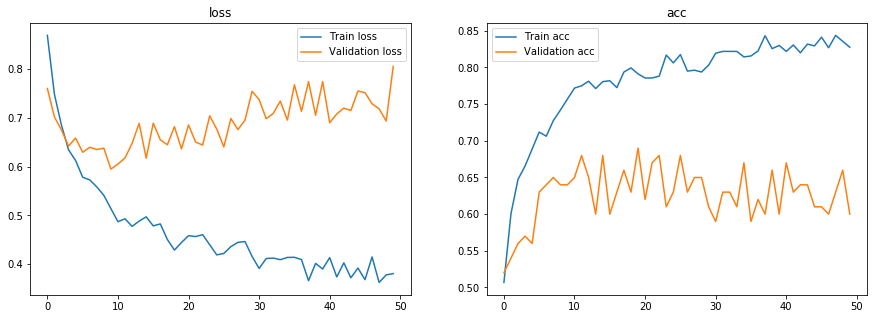

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
ax[0].legend()
ax[1].legend()

In [9]:
if os.path.exists('./keras.model'):
    model = load_model('./keras.model')
elif os.path.exists('./inceptionresnetv2-classificator/keras.model'):
    model = load_model('./inceptionresnetv2-classificator/keras.model')
    !cp "./inceptionresnetv2-classificator/keras.model" "./"

In [10]:
validation_generator = train_data_generator.create(
    validation_image_annotations, 100, (299,299,3))

In [11]:
true_labels = []; predict_labels = []; 
for i in range(50):
    imgs, labels = next(validation_generator)
    true_labels += [int(label) for label in labels]
    predict_labels += [float(predict) for predict in model.predict(imgs)]

In [12]:
true_labels = np.array(true_labels)
predict_labels = (np.array(predict_labels) > 0.5).astype(int)

In [13]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(true_labels, predict_labels),
    columns=[['predict', 'predict'],['N', 'P']],
    index=[['true', 'true'],['N', 'P']])

predict     
             N    P
true N    2845   80
     P    1556  519

In [14]:
from sklearn.metrics import f1_score
f1_score(true_labels, predict_labels, average='macro')

0.5824341374079594